# Regression and Classification with Tree Models

In this notebook, we'll tackle regression and classification tasks using tree-based models. For regression, we'll predict benzene concentrations (C6H6(GT)) using the Air Quality dataset, and for classification, we'll predict whether it will rain tomorrow (RainTomorrow) using the WeatherAUS dataset.

## Regression Problem: Air Quality Dataset

### Data Loading and Preprocessing

First, we'll load the dataset and perform necessary preprocessing steps. We'll be careful to prevent data leakage by splitting the data before any transformations. We'll import necessary libraries.


In [ ]:
!pip uninstall -y scikit-learn xgboost
!pip install --no-cache-dir --force-reinstall \
    "scikit-learn==1.3.2" \
    "xgboost==2.1.3" \
    "numpy<2.0" \
    "scipy<1.14.0"

import sklearn
import xgboost
import numpy
import scipy

print("scikit-learn:", sklearn.__version__)
print("xgboost:", xgboost.__version__)
print("numpy:", numpy.__version__)
print("scipy:", scipy.__version__)

Found existing installation: scikit-learn 1.3.2
Uninstalling scikit-learn-1.3.2:
  Successfully uninstalled scikit-learn-1.3.2
Found existing installation: xgboost 2.1.3
Uninstalling xgboost-2.1.3:
  Successfully uninstalled xgboost-2.1.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 195.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 265.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 248.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 250.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 237.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 221.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 226.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 230.0 MB/s eta 0:00:00
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.5.0
    Uninstalling thr

scikit-learn: 1.3.2
xgboost: 2.1.3
numpy: 1.26.4
scipy: 1.13.1


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import io
import zipfile
import warnings
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    classification_report
)

Load the Air Quality dataset using the provided code and fix the decimal and -200 issues.

In [ ]:
url = 'https://static.cdn.epam.com/uploads/583f9e4a37492715074c531dbd5abad2/ds/data.%20module%202.%20Regression.zip'
response = requests.get(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))
data = pd.read_csv(zip_file.open('data. module 2. Regression/AirQualityUCI.csv'), sep=';', decimal=',', usecols=range(15), na_values=-200)
print(data.head())

         Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  10/03/2004  18.00.00     2.6       1360.0     150.0      11.9   
1  10/03/2004  19.00.00     2.0       1292.0     112.0       9.4   
2  10/03/2004  20.00.00     2.2       1402.0      88.0       9.0   
3  10/03/2004  21.00.00     2.2       1376.0      80.0       9.2   
4  10/03/2004  22.00.00     1.6       1272.0      51.0       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0         1046.0    166.0        1056.0    113.0        1692.0       1268.0   
1          955.0    103.0        1174.0     92.0        1559.0        972.0   
2          939.0    131.0        1140.0    114.0        1555.0       1074.0   
3          948.0    172.0        1092.0    122.0        1584.0       1203.0   
4          836.0    131.0        1205.0    116.0        1490.0       1110.0   

      T    RH      AH  
0  13.6  48.9  0.7578  
1  13.3  47.7  0.7255  
2  11.9  54.0  0.7502  
3  11.0  60.0  0.786

We'll drop rows where the target has missing values because the target variable is what the model learns to predict, and missing values in it provide no meaningful information, potentially introducing bias if imputed.

In [ ]:
print("Shape before dropping missing target rows:", data.shape)

data = data.dropna(subset=['C6H6(GT)'])

print("Shape after dropping missing target rows:", data.shape)

Shape before dropping missing target rows: (9471, 15)
Shape after dropping missing target rows: (8991, 15)


Takeaway. About 5.07% of the rows were dropped due to missing target values. Not bad, still plenty of data left to work with.

We'll define features and target variable, then split the data to avoid data leakage.

In [ ]:
X = data.drop(['Date', 'Time', 'C6H6(GT)', 'PT08.S2(NMHC)'], axis=1)
y = data['C6H6(GT)']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

We'll handle missing values in the training and testing sets separately. We'll impute missing values because data is "gold" and we can miss patterns by dropping.


In [ ]:
imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

y_train = y_train.fillna(y_train.median())
y_test = y_test.fillna(y_train.median())

We'll scale the features after splitting to prevent data leakage.

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

feature_names = X.columns

### Modeling

Now, we'll build and evaluate our models. Metrics chosen justification and reasoning as follows: MAE shows average error, MSE highlights sensitivity to outliers, and R² explains how well the model captures variance. Together, they help judge accuracy and reliability.

#### Decision Tree Regressor

We'll train and evaluate the Decision Tree Regressor.

In [ ]:
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_train, y_train)

y_pred_dt = dt_regressor.predict(X_test)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)
print(f"Decision Tree Regressor MAE: {mae_dt:.2f}")
print(f"Decision Tree Regressor MSE: {mse_dt:.2f}")
print(f"Decision Tree Regressor R2 Score: {r2_dt:.2f}")

Decision Tree Regressor MAE: 1.25
Decision Tree Regressor MSE: 6.13
Decision Tree Regressor R2 Score: 0.89


Interesting to see how the model performs with default parameters.

We'll explore the impact of the `max_depth` hyperparameter.

In [ ]:
r2_scores = []
for depth in [5, 10, 15, 20, None]:
    dt = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    r2_scores.append((depth, r2))
    print(f"Max Depth: {depth}, R2 Score: {r2}")

Max Depth: 5, R2 Score: 0.8837762993891001
Max Depth: 10, R2 Score: 0.8874526542949488
Max Depth: 15, R2 Score: 0.8923171214398677
Max Depth: 20, R2 Score: 0.8920408902714642
Max Depth: None, R2 Score: 0.8933087392568617


As we increase max depth, we capture more variance in the data.

We'll perform hyperparameter tuning using GridSearchCV.

The `max_depth` controls how deep the tree can grow (to prevent overfitting), and `min_samples_split` ensures splits only happen when a node has enough data, keeping the model simple and avoiding overly specific splits.

The `scoring='r2'` is chosen because the R² metric evaluates how well the model explains the variance in the target variable, making it ideal for assessing regression model performance.

In [ ]:
param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)
best_dt = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'max_depth': 15, 'min_samples_split': 10}


We'll evaluate the tuned Decision Tree Regressor.

In [ ]:
y_pred_best_dt = best_dt.predict(X_test)
mae_best_dt = mean_absolute_error(y_test, y_pred_best_dt)
mse_best_dt = mean_squared_error(y_test, y_pred_best_dt)
r2_best_dt = r2_score(y_test, y_pred_best_dt)
print(f"Tuned Decision Tree Regressor MAE: {mae_best_dt:.2f}")
print(f"Tuned Decision Tree Regressor MSE: {mse_best_dt:.2f}")
print(f"Tuned Decision Tree Regressor R2 Score: {r2_best_dt:.2f}")

Tuned Decision Tree Regressor MAE: 1.22
Tuned Decision Tree Regressor MSE: 6.03
Tuned Decision Tree Regressor R2 Score: 0.90


It's clear that hyperparameter tuning has improved the model performance.

We'll plot feature importances.

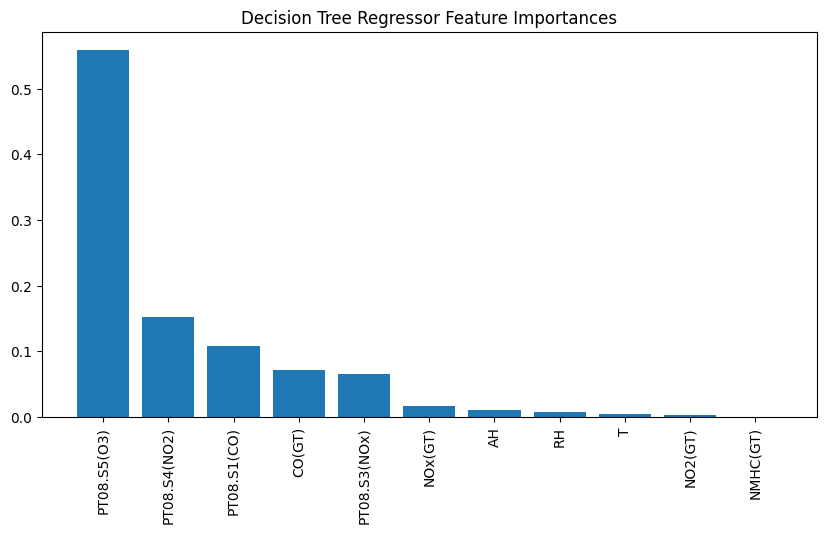

In [ ]:
importances = best_dt.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,5))
plt.title("Decision Tree Regressor Feature Importances")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.show()

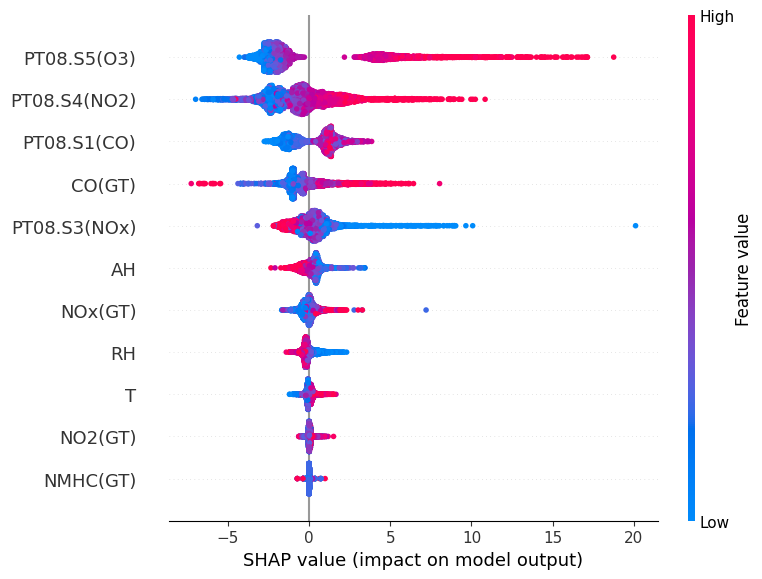

In [ ]:
explainer_dt = shap.TreeExplainer(best_dt)
shap_values_dt = explainer_dt.shap_values(X_train)

shap.summary_plot(shap_values_dt, X_train, feature_names=feature_names)

Takeaway. The ozone concentration `PT08.S5(O3)` is the most influential feature, playing a key role in shaping predictions.

We'll visualize the decision tree.

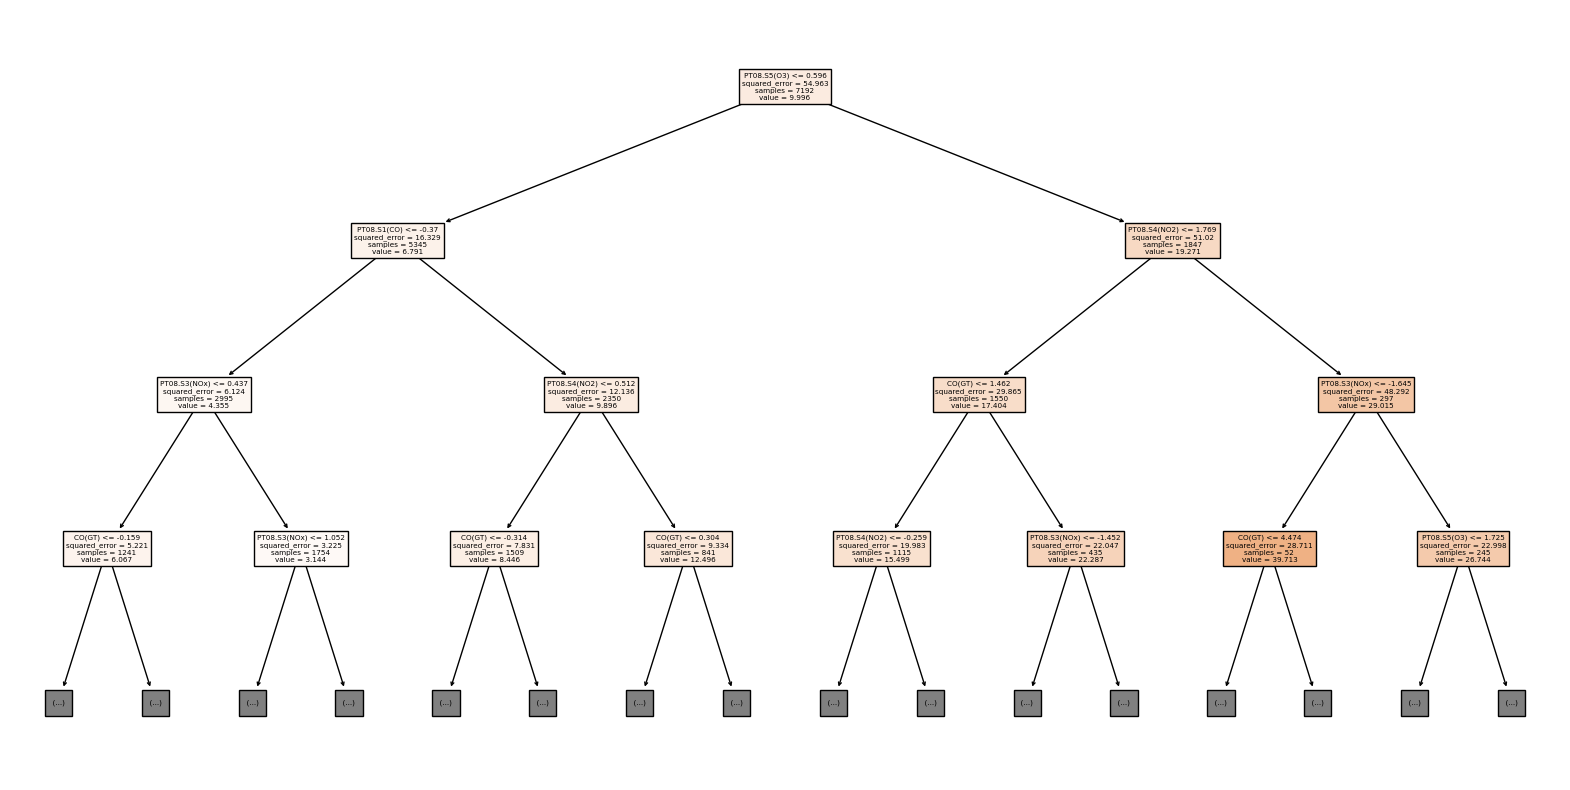

In [ ]:
plt.figure(figsize=(20,10))
plot_tree(best_dt, feature_names=feature_names, filled=True, max_depth=3)
plt.show()

This decision tree visualization clearly shows how each feature-based split guides the model toward increasingly precise predictions by narrowing down the data at each branch.


#### Random Forest Regressor

We'll train and evaluate the Random Forest Regressor.

In [ ]:
rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(X_train, y_train)

y_pred_rf = rf_regressor.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest Regressor MAE: {mae_rf:.2f}")
print(f"Random Forest Regressor MSE: {mse_rf:.2f}")
print(f"Random Forest Regressor R2 Score: {r2_rf:.2f}")

Random Forest Regressor MAE: 0.78
Random Forest Regressor MSE: 1.70
Random Forest Regressor R2 Score: 0.97


The Random Forest model shows better performance compared to the Decision Tree.

We'll experiment with different numbers of estimators.

In [ ]:
estimators = [50, 100, 200, 300]

for n in estimators:
    rf = RandomForestRegressor(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Estimators: {n}, R2 Score: {r2:.2f}, MAE: {mae:.2f}, MSE: {mse:.2f}")

Estimators: 50, R2 Score: 0.97, MAE: 0.79, MSE: 1.75
Estimators: 100, R2 Score: 0.97, MAE: 0.78, MSE: 1.70
Estimators: 200, R2 Score: 0.97, MAE: 0.78, MSE: 1.75
Estimators: 300, R2 Score: 0.97, MAE: 0.77, MSE: 1.71


Increasing estimators beyond 100 brings minimal gains, with R2 stable at 0.97 and slight MAE/MSE improvements.

We'll perform hyperparameter tuning for Random Forest.

The `n_estimators` sets the number of trees in the forest (balancing performance and computation time), while `max_depth` controls how deep each tree can grow to prevent overfitting and keep the model generalizable.

In [ ]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None]
}
grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=5, scoring='r2')
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_
print(f"Best Parameters: {grid_search_rf.best_params_}")

Best Parameters: {'max_depth': None, 'n_estimators': 300}


GridSearchCV selects 300 estimators for optimal balance and robustness.

We'll evaluate the tuned Random Fores.

In [ ]:
y_pred_best_rf = best_rf.predict(X_test)
mae_best_rf = mean_absolute_error(y_test, y_pred_best_rf)
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)
print(f"Tuned Random Forest Regressor MAE: {mae_best_rf:.2f}")
print(f"Tuned Random Forest Regressor MSE: {mse_best_rf:.2f}")
print(f"Tuned Random Forest Regressor R2 Score: {r2_best_rf:.2f}")

Tuned Random Forest Regressor MAE: 0.77
Tuned Random Forest Regressor MSE: 1.71
Tuned Random Forest Regressor R2 Score: 0.97


The tuned Random Forest model performs sligtly better.

We'll plot feature importances.

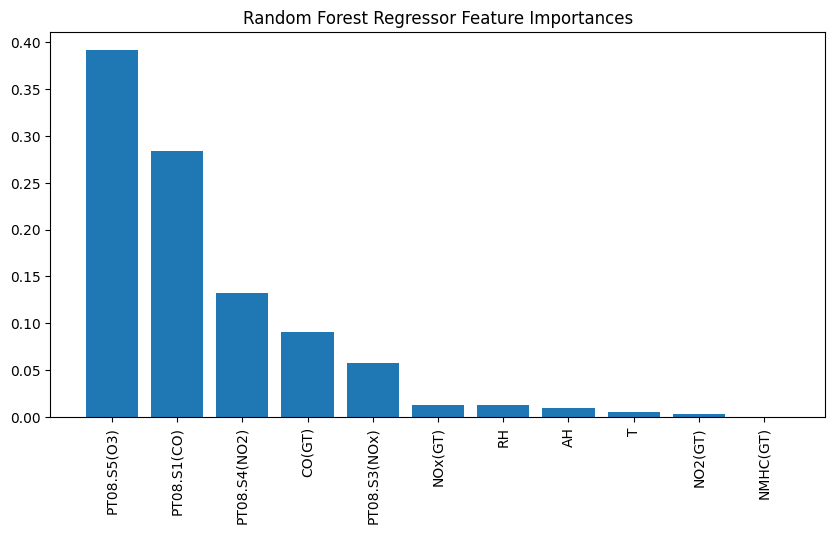

In [ ]:
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,5))
plt.title("Random Forest Regressor Feature Importances")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.show()

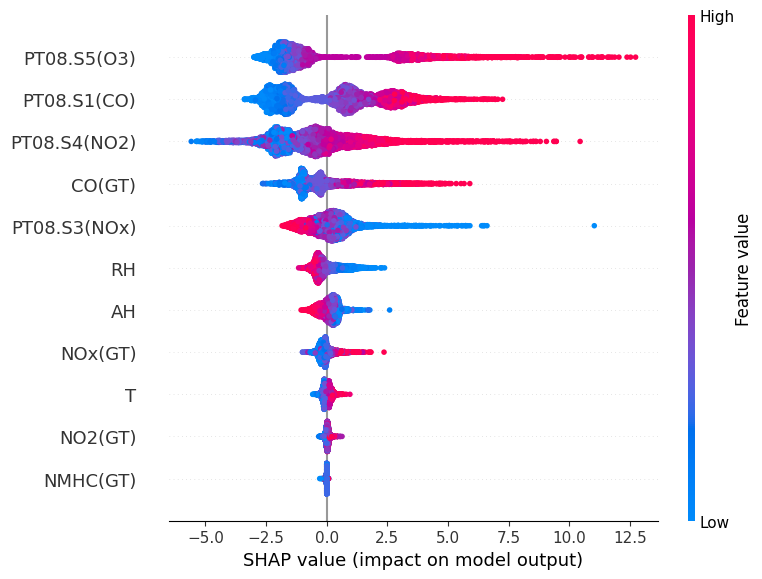

In [ ]:
explainer_rf = shap.TreeExplainer(best_rf)
shap_values_rf = explainer_rf.shap_values(X_train)

shap.summary_plot(shap_values_rf, X_train, feature_names=feature_names)

Takeaway. The SHAP summary plot shows that `PT08.S5(O3)` (ozone concentration) is the most influential feature with high values increasing the model's predictions significantly.

#### XGBoost Regressor

We'll train and evaluate the XGBoost Regressor.

The `objective='reg:squarederror'` is used in XGBoost for regression task, as it minimizes the squared error between predictions and actual values, which is a standard loss function for regression problems.

In [ ]:
xgb_regressor = XGBRegressor(random_state=42, objective='reg:squarederror')
xgb_regressor.fit(X_train, y_train)

y_pred_xgb = xgb_regressor.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost Regressor MAE: {mae_xgb:.2f}")
print(f"XGBoost Regressor MSE: {mse_xgb:.2f}")
print(f"XGBoost Regressor R2 Score: {r2_xgb:.2f}")

XGBoost Regressor MAE: 0.78
XGBoost Regressor MSE: 1.49
XGBoost Regressor R2 Score: 0.97


XGBoost shows strong performance right out of the box.

We'll experiment with different learning rates.

In [ ]:
learning_rates = [0.01, 0.1, 0.2]
for lr in learning_rates:
    xgb = XGBRegressor(random_state=42, learning_rate=lr, objective='reg:squarederror')
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"Learning Rate: {lr}, R2 Score: {r2:.2f}")

Learning Rate: 0.01, R2 Score: 0.80
Learning Rate: 0.1, R2 Score: 0.98
Learning Rate: 0.2, R2 Score: 0.98


We'll perform hyperparameter tuning.

The `n_estimators` sets the number of trees in the ensemble, `max_depth` controls tree complexity to prevent overfitting, and `learning_rate` adjusts the pace of learning and balances training stability.

In [ ]:
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}
grid_search_xgb = GridSearchCV(XGBRegressor(random_state=42, objective='reg:squarederror'), param_grid_xgb, cv=5, scoring='r2')
grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_
print(f"Best Parameters: {grid_search_xgb.best_params_}")

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


We'll evaluate the tuned model.

In [ ]:
y_pred_best_xgb = best_xgb.predict(X_test)
mae_best_xgb = mean_absolute_error(y_test, y_pred_best_xgb)
mse_best_xgb = mean_squared_error(y_test, y_pred_best_xgb)
r2_best_xgb = r2_score(y_test, y_pred_best_xgb)
print(f"Tuned XGBoost Regressor MAE: {mae_best_xgb:.2f}")
print(f"Tuned XGBoost Regressor MSE: {mse_best_xgb:.2f}")
print(f"Tuned XGBoost Regressor R2 Score: {r2_best_xgb:.2f}")

Tuned XGBoost Regressor MAE: 0.71
Tuned XGBoost Regressor MSE: 1.17
Tuned XGBoost Regressor R2 Score: 0.98


The tuned XGBoost model provides the best performance among all.

We'll plot feature importances.

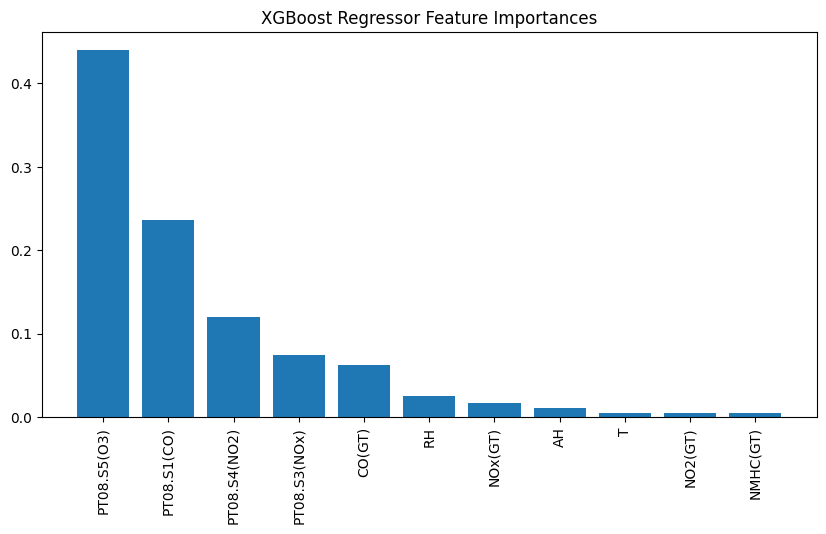

In [ ]:
importances = best_xgb.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,5))
plt.title("XGBoost Regressor Feature Importances")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.show()

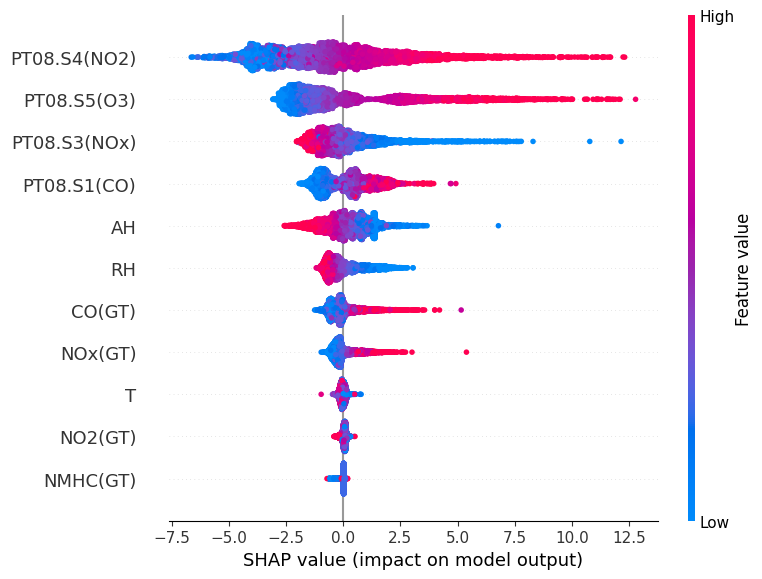

In [ ]:
explainer_reg = shap.TreeExplainer(best_xgb)
shap_values_reg = explainer_reg.shap_values(X_train)

shap.summary_plot(shap_values_reg, X_train, feature_names=feature_names)

Takeaway. The SHAP summary plot highlights `PT08.S4(NO2)` (nitrogen dioxide) and `PT08.S5(O3)` (ozone) as the most influential features with higher values of these gases significantly increasing the model's predictions.

### Model Comparison

We'll compile results from all models.

In [ ]:
results = pd.DataFrame({
    'Model': ['Decision Tree', 'Tuned Decision Tree', 'Random Forest', 'Tuned Random Forest', 'XGBoost', 'Tuned XGBoost'],
    'R2 Score': [r2_dt, r2_best_dt, r2_rf, r2_best_rf, r2_xgb, r2_best_xgb],
    'MAE': [mae_dt, mae_best_dt, mae_rf, mae_best_rf, mae_xgb, mae_best_xgb],
    'MSE': [mse_dt, mse_best_dt, mse_rf, mse_best_rf, mse_xgb, mse_best_xgb]
})

results = results.round(2)

display(results)

,Model,R2 Score,MAE,MSE
0,Decision Tree,0.89,1.25,6.13
1,Tuned Decision Tree,0.90,1.22,6.03
2,Random Forest,0.97,0.78,1.70
3,Tuned Random Forest,0.97,0.77,1.71
4,XGBoost,0.97,0.78,1.49
5,Tuned XGBoost,0.98,0.71,1.17


In [ ]:
prev_regression_data = pd.DataFrame({
    'Model': ['Baseline (Linear)', 'Ridge', 'Lasso'],
    'R2 Score': [0.940257, 0.940254, 0.940254],
    'MAE': [1.335300, 1.335216, 1.335157],
    'MSE': [3.282431, 3.282618, 3.282631]
})

prev_regression_data = prev_regression_data.round(2)

display(prev_regression_data)

Takeaway. The Tuned XGBoost model is the top performer with the best R^2 and lowest errors, outperforming both tree-based and linear models with its ability to capture complex patterns.

## Classification Problem: WeatherAUS Dataset

### Data Loading and Preprocessing

We'll load the WeatherAUS dataset using the provided code.

In [ ]:
url = 'https://static.cdn.epam.com/uploads/583f9e4a37492715074c531dbd5abad2/ds/data.%20module%203.%20Classification.zip'
response = requests.get(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))
data = pd.read_csv(zip_file.open('data. module 3. Classification/weatherAUS.csv'))
print(data.head())

         Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7    

We'll define the target variable and encode it.

In [ ]:
data['RainTomorrow'] = data['RainTomorrow'].map({'No': 0, 'Yes': 1})

We'll drop rows with missing target values.

In [ ]:
data.dropna(subset=['RainTomorrow'], inplace=True)

We'll split the data into features and target, then into training and testing sets.

In [ ]:
X = data.drop(['RainTomorrow', 'Date'], axis=1)
y = data['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

We'll handle missing values separately in training and testing sets.

We'll impute missing values because data is "gold" and we can miss patterns by dropping.

In [ ]:
imputer_num = SimpleImputer(strategy='mean')
imputer_cat = SimpleImputer(strategy='most_frequent')

num_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns

X_train[num_cols] = imputer_num.fit_transform(X_train[num_cols])
X_test[num_cols] = imputer_num.transform(X_test[num_cols])

X_train[cat_cols] = imputer_cat.fit_transform(X_train[cat_cols])
X_test[cat_cols] = imputer_cat.transform(X_test[cat_cols])

We'll encode categorical variables.

In [ ]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

We'll scale numerical features after splitting.

In [ ]:
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

feature_names = X_train.columns

### Modeling

Now, we'll build and evaluate our models.


Recall scoring was prioritized due to the goal of detecting rainy days with minimal false negatives. And accuracy is useful but the dataset can be imbalanced in terms of target distribution.

#### Decision Tree Classifier

We'll train and evaluate the Decision Tree Classifier.

In [ ]:
def evaluate_classifier(model, X_test, y_test):
    y_pred = model.predict(X_test)
    metrics = {
        "accuracy": round(accuracy_score(y_test, y_pred), 2),
        "recall": round(recall_score(y_test, y_pred), 2),
        "precision": round(precision_score(y_test, y_pred), 2),
        "f1_score": round(f1_score(y_test, y_pred), 2)
    }
    return metrics

dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

dt_metrics = evaluate_classifier(dt_classifier, X_test, y_test)
print("Decision Tree Classifier Metrics:", dt_metrics)

Decision Tree Classifier Metrics: {'accuracy': 0.79, 'recall': 0.55, 'precision': 0.52, 'f1_score': 0.53}


The recall is relatively low due to class imbalance.

We'll apply class weighting to handle imbalance.

In [ ]:
dt_classifier_weighted = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_classifier_weighted.fit(X_train, y_train)

dt_weighted_metrics = evaluate_classifier(dt_classifier_weighted, X_test, y_test)

print("Weighted Decision Tree Classifier Metrics:", dt_weighted_metrics)

Weighted Decision Tree Classifier Metrics: {'accuracy': 0.79, 'recall': 0.53, 'precision': 0.53, 'f1_score': 0.53}


The recall has not improved after applying class weighting.

We'll perform hyperparameter tuning.

The `max_depth` parameter limits the depth of the tree to control overfitting and ensure the model remains generalizable, while `min_samples_split` ensures that splits occur only when a node has enough samples, preventing overly specific and unstable splits.

In [ ]:
param_grid_dt = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10]
}
grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=42, class_weight='balanced'), param_grid_dt, cv=5, scoring='recall')
grid_search_dt.fit(X_train, y_train)
best_dt = grid_search_dt.best_estimator_
print(f"Best Parameters: {grid_search_dt.best_params_}")

Best Parameters: {'max_depth': 10, 'min_samples_split': 10}


We'll evaluate the tuned model.

In [ ]:
best_dt_metrics = evaluate_classifier(best_dt, X_test, y_test)

print("Tuned Decision Tree Classifier Metrics:", best_dt_metrics)

Tuned Decision Tree Classifier Metrics: {'accuracy': 0.77, 'recall': 0.76, 'precision': 0.5, 'f1_score': 0.6}


The recall has improved after tuning.

We'll plot feature importances.

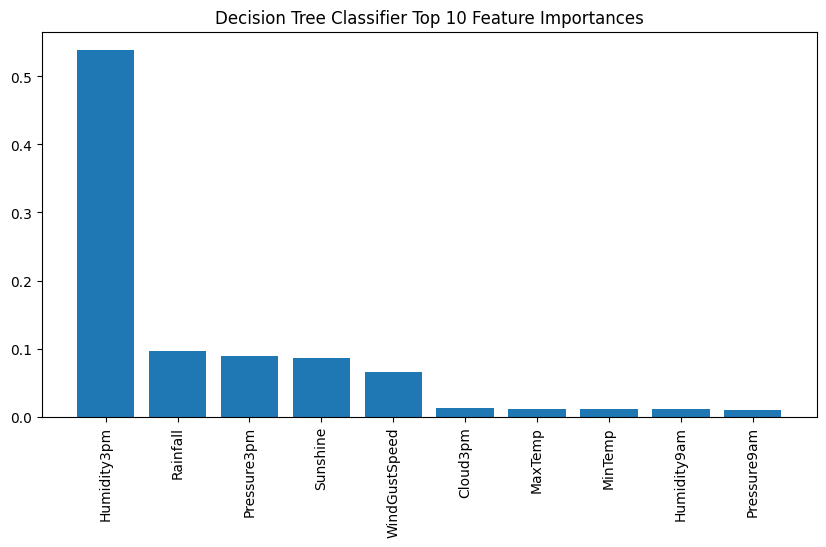

In [ ]:
importances = best_dt.feature_importances_
indices = np.argsort(importances)[::-1][:10]
plt.figure(figsize=(10,5))
plt.title("Decision Tree Classifier Top 10 Feature Importances")
plt.bar(range(10), importances[indices])
plt.xticks(range(10), [feature_names[i] for i in indices], rotation=90)
plt.show()

The top features influencing the model are displayed.

SHAP values shape: (113754, 110, 2)
X_train shape: (113754, 110)
Number of features: 110
Final SHAP values shape (for class 1): (113754, 110)


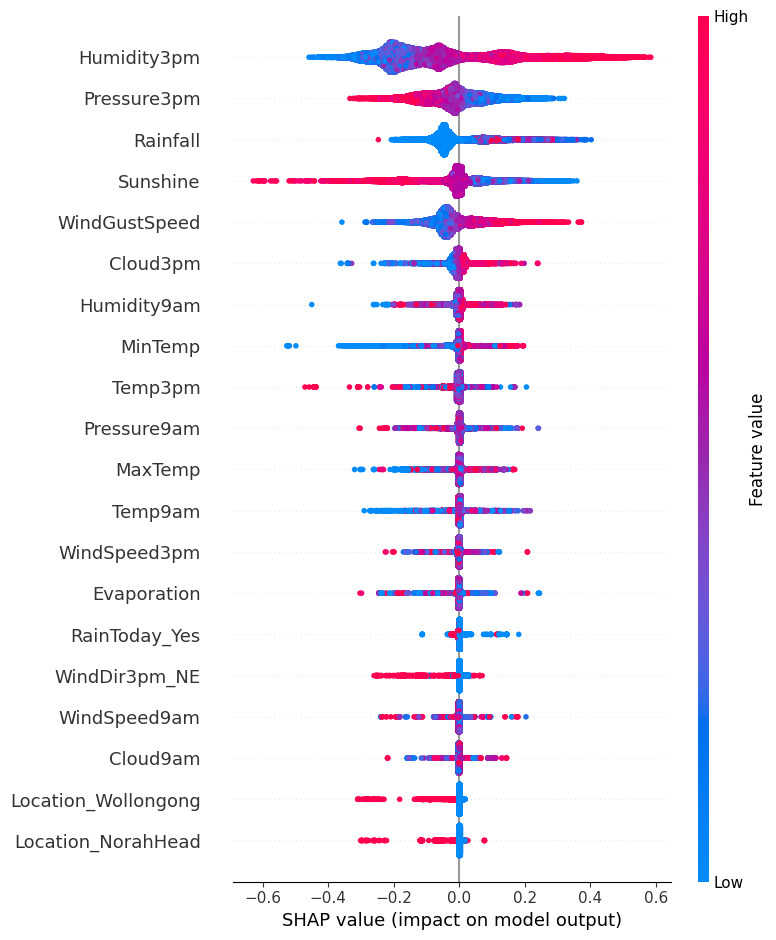

In [ ]:
feature_names = X_train.columns

explainer_dt_clf = shap.TreeExplainer(best_dt)
shap_values_dt_clf = explainer_dt_clf.shap_values(X_train)

print("SHAP values shape:", np.array(shap_values_dt_clf).shape)
print("X_train shape:", X_train.shape)
print("Number of features:", len(feature_names))

shap_values_for_class = shap_values_dt_clf[:, :, 1]

print("Final SHAP values shape (for class 1):", shap_values_for_class.shape)

X_data_for_shap = X_train.values

shap.summary_plot(shap_values_for_class, X_data_for_shap, feature_names=feature_names)

Takeaway. Humidity at 3pm stands out as the most important feature with higher humidity values having a significant impact on the model's predictions.

#### Random Forest Classifier

We'll train and evaluate the Random Forest Classifier.

In [ ]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

rf_metrics = evaluate_classifier(rf_classifier, X_test, y_test)

print("Random Forest Classifier Metrics:", rf_metrics)

Random Forest Classifier Metrics: {'accuracy': 0.86, 'recall': 0.5, 'precision': 0.78, 'f1_score': 0.61}


We'll apply class weighting.

In [ ]:
rf_classifier_weighted = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_classifier_weighted.fit(X_train, y_train)

rf_weighted_metrics = evaluate_classifier(rf_classifier_weighted, X_test, y_test)

print("Weighted Random Forest Classifier Metrics:", rf_weighted_metrics)

Weighted Random Forest Classifier Metrics: {'accuracy': 0.85, 'recall': 0.49, 'precision': 0.79, 'f1_score': 0.6}


Recall doesn't improve with class weighting.

We'll perform hyperparameter tuning.

The `n_estimators` parameter sets the number of trees in the forest to balance prediction accuracy and computational cost, while `max_depth` controls the maximum depth of each tree to prevent overfitting and ensure the model generalizes well.

In [ ]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None]
}
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'), param_grid_rf, cv=5, scoring='recall')
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_
print(f"Best Parameters: {grid_search_rf.best_params_}")

Best Parameters: {'max_depth': 10, 'n_estimators': 200}


We'll evaluate the tuned model.

In [ ]:
best_rf_metrics = evaluate_classifier(best_rf, X_test, y_test)
print("Tuned Random Forest Classifier Metrics:", best_rf_metrics)

Tuned Random Forest Classifier Metrics: {'accuracy': 0.8, 'recall': 0.77, 'precision': 0.53, 'f1_score': 0.63}


We can observe improvement in recall.

We'll plot feature importances.

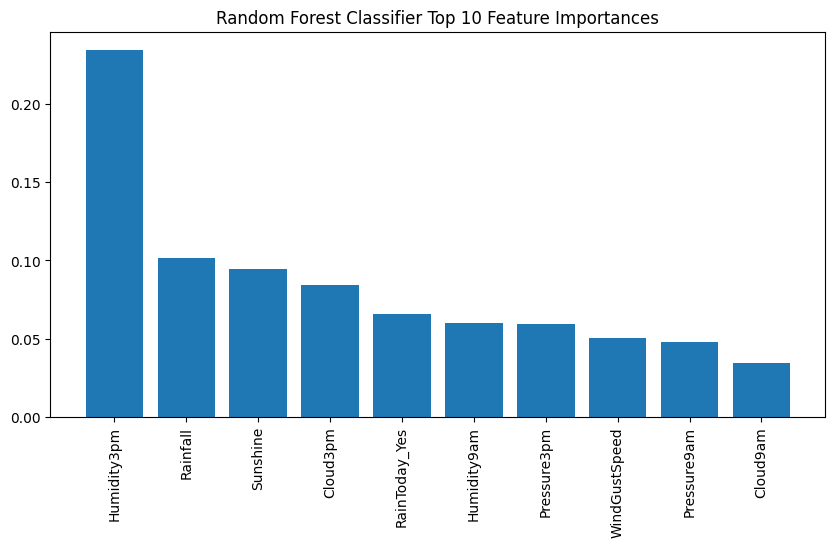

In [ ]:
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1][:10]
plt.figure(figsize=(10,5))
plt.title("Random Forest Classifier Top 10 Feature Importances")
plt.bar(range(10), importances[indices])
plt.xticks(range(10), [feature_names[i] for i in indices], rotation=90)
plt.show()

Important features influencing the Random Forest model.

SHAP values shape: (113754, 110, 2)
X_train shape: (113754, 110)
Number of features: 110
Final SHAP values shape (for class 1, RF): (113754, 110)


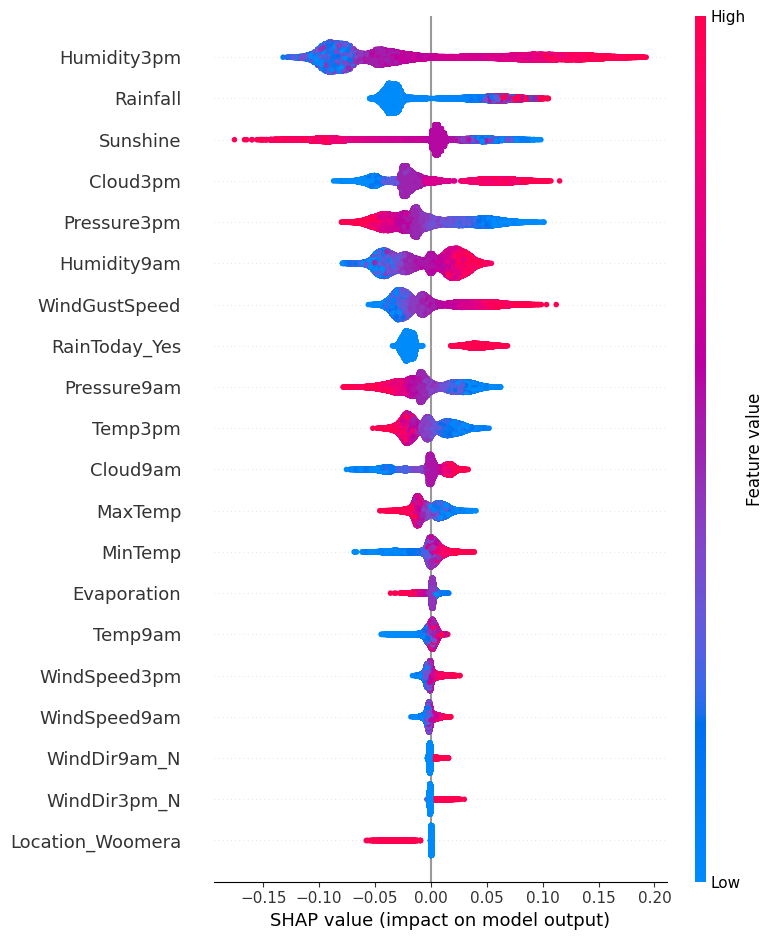

In [ ]:
feature_names = X_train.columns

explainer_rf_clf = shap.TreeExplainer(best_rf)
shap_values_rf_clf = explainer_rf_clf.shap_values(X_train)

print("SHAP values shape:", np.array(shap_values_rf_clf).shape)
print("X_train shape:", X_train.shape)
print("Number of features:", len(feature_names))

shap_values_for_class_rf = shap_values_rf_clf[:, :, 1]

print("Final SHAP values shape (for class 1, RF):", shap_values_for_class_rf.shape)

X_data_for_shap = X_train.values

shap.summary_plot(shap_values_for_class_rf, X_data_for_shap, feature_names=feature_names)

Takeaway. Humidity at 3pm is the most influential feature with higher values strongly impacting the model's predictions.

#### XGBoost Classifier

We'll train and evaluate the XGBoost Classifier.

The `eval_metric='logloss'` is used in XGBoost for classification task as it evaluates the model's performance by measuring the logarithmic loss, which penalizes incorrect predictions with higher confidence, making it ideal for probabilistic classification models.

In [ ]:
xgb_classifier = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_classifier.fit(X_train, y_train)

xgb_metrics = evaluate_classifier(xgb_classifier, X_test, y_test)
print("XGBoost Classifier Metrics:", xgb_metrics)

XGBoost Classifier Metrics: {'accuracy': 0.86, 'recall': 0.56, 'precision': 0.75, 'f1_score': 0.64}


We'll apply scale_pos_weight to handle imbalance.

The `scale_pos_weight` is used to adjust the model's focus on the minority class ("RainTomorrow" = Yes) by setting it based on the ratio of the majority class to the minority class, helping to improve recall for the minority class in imbalanced target.

In [ ]:
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
xgb_classifier_weighted = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=ratio)
xgb_classifier_weighted.fit(X_train, y_train)

xgb_weighted_metrics = evaluate_classifier(xgb_classifier_weighted, X_test, y_test)
print("Weighted XGBoost Classifier Metrics:", xgb_weighted_metrics)

Weighted XGBoost Classifier Metrics: {'accuracy': 0.82, 'recall': 0.78, 'precision': 0.57, 'f1_score': 0.66}


The recall improves after handling imbalance.

We'll perform hyperparameter tuning for XGBoost.

The `n_estimators` parameter sets the number of trees in the ensemble, `max_depth` limits the complexity of each tree to prevent overfitting, and `learning_rate` ensures a smoother and more stable learning process.

In [ ]:
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}
grid_search_xgb = GridSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=ratio), param_grid_xgb, cv=5, scoring='recall')
grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_
print(f"Best Parameters: {grid_search_xgb.best_params_}")

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


We'll evaluate the tuned model.

In [ ]:
best_xgb_metrics = evaluate_classifier(best_xgb, X_test, y_test)
print("Tuned XGBoost Classifier Metrics:", best_xgb_metrics)

Tuned XGBoost Classifier Metrics: {'accuracy': 0.81, 'recall': 0.8, 'precision': 0.56, 'f1_score': 0.66}


The tuned XGBoost model shows the highest recall.

We'll plot feature importances.

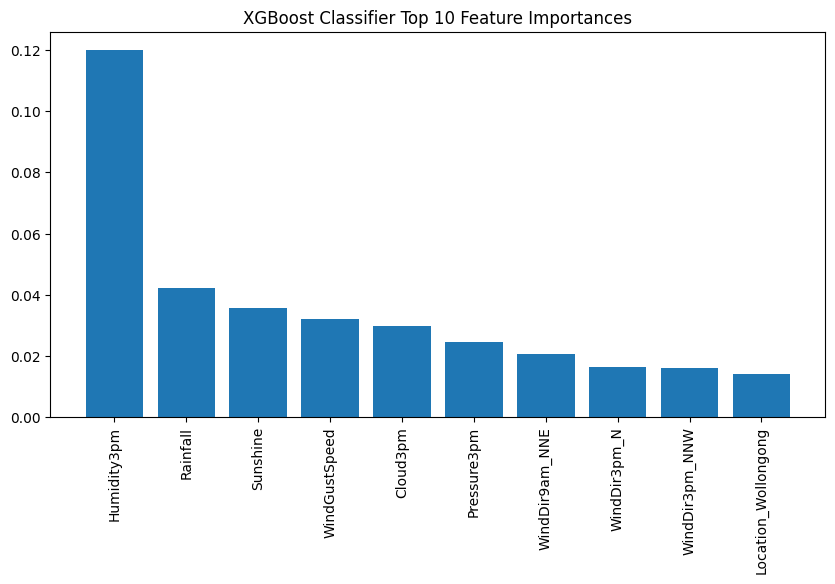

In [ ]:
importances = best_xgb.feature_importances_
indices = np.argsort(importances)[::-1][:10]
plt.figure(figsize=(10,5))
plt.title("XGBoost Classifier Top 10 Feature Importances")
plt.bar(range(10), importances[indices])
plt.xticks(range(10), [X_train.columns[i] for i in indices], rotation=90)
plt.show()

Let's look at important features via SHAP that influence the XGBoost model.

SHAP values shape: (113754, 110)
X_train shape: (113754, 110)
Number of features: 110


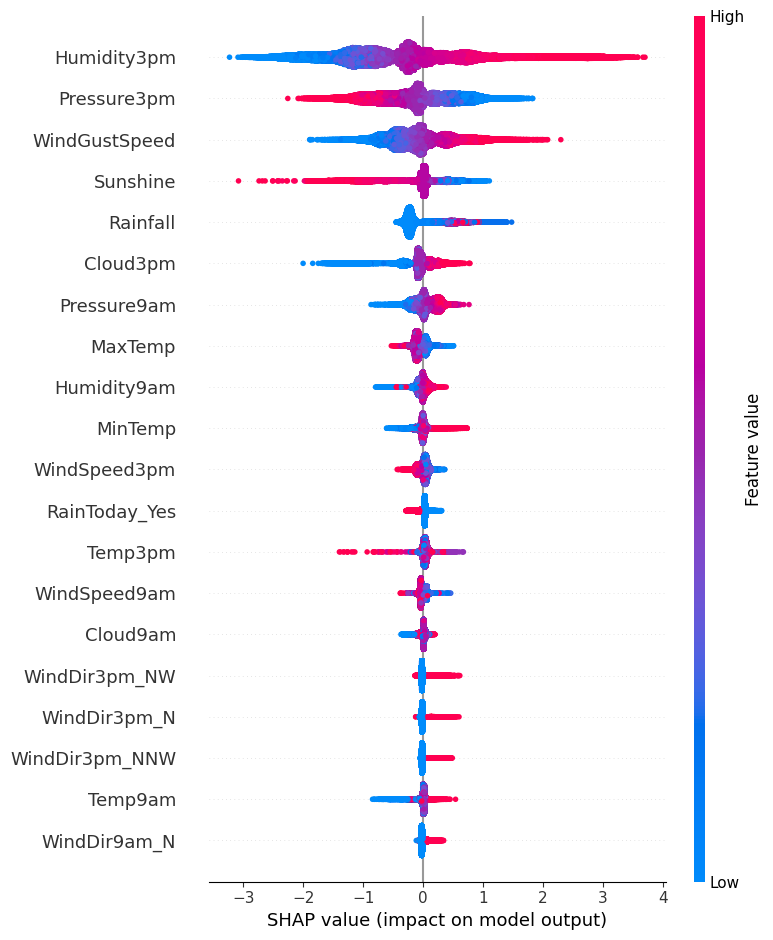

In [ ]:
feature_names = X_train.columns

explainer_xgb_clf = shap.TreeExplainer(best_xgb)
shap_values_xgb_clf = explainer_xgb_clf.shap_values(X_train)

print("SHAP values shape:", np.array(shap_values_xgb_clf).shape)
print("X_train shape:", X_train.shape)
print("Number of features:", len(feature_names))

X_data_for_shap = X_train.values

shap.summary_plot(shap_values_xgb_clf, X_data_for_shap, feature_names=feature_names)

Takeaway. Humidity at 3pm is the most impactful feature with higher values strongly influencing the model's predictions.

### Model Comparison

We'll compile results from all models.

In [ ]:
results = pd.DataFrame({
    'Model': ['Decision Tree', 'Weighted Decision Tree', 'Tuned Decision Tree',
              'Random Forest', 'Weighted Random Forest', 'Tuned Random Forest',
              'XGBoost', 'Weighted XGBoost', 'Tuned XGBoost'],
    'Accuracy': [
        dt_metrics['accuracy'], dt_weighted_metrics['accuracy'], best_dt_metrics['accuracy'],
        rf_metrics['accuracy'], rf_weighted_metrics['accuracy'], best_rf_metrics['accuracy'],
        xgb_metrics['accuracy'], xgb_weighted_metrics['accuracy'], best_xgb_metrics['accuracy']
    ],
    'Recall': [
        dt_metrics['recall'], dt_weighted_metrics['recall'], best_dt_metrics['recall'],
        rf_metrics['recall'], rf_weighted_metrics['recall'], best_rf_metrics['recall'],
        xgb_metrics['recall'], xgb_weighted_metrics['recall'], best_xgb_metrics['recall']
    ],
    'Precision': [
        dt_metrics['precision'], dt_weighted_metrics['precision'], best_dt_metrics['precision'],
        rf_metrics['precision'], rf_weighted_metrics['precision'], best_rf_metrics['precision'],
        xgb_metrics['precision'], xgb_weighted_metrics['precision'], best_xgb_metrics['precision']
    ],
    'F1-Score': [
        dt_metrics['f1_score'], dt_weighted_metrics['f1_score'], best_dt_metrics['f1_score'],
        rf_metrics['f1_score'], rf_weighted_metrics['f1_score'], best_rf_metrics['f1_score'],
        xgb_metrics['f1_score'], xgb_weighted_metrics['f1_score'], best_xgb_metrics['f1_score']
    ]
})

display(results)

,Model,Accuracy,Recall,Precision,F1-Score
0,Decision Tree,0.79,0.55,0.52,0.53
1,Weighted Decision Tree,0.79,0.53,0.53,0.53
2,Tuned Decision Tree,0.77,0.76,0.50,0.60
3,Random Forest,0.86,0.50,0.78,0.61
4,Weighted Random Forest,0.85,0.49,0.79,0.60
5,Tuned Random Forest,0.80,0.77,0.53,0.63
6,XGBoost,0.86,0.56,0.75,0.64
7,Weighted XGBoost,0.82,0.78,0.57,0.66
8,Tuned XGBoost,0.81,0.80,0.56,0.66


In [ ]:
classification_data = {
    'Model': [
        'LogReg_none', 'LogReg_undersample', 'LogReg_oversample', 'LogReg_smote', 'LogReg_weighted',
        'KNN_none', 'KNN_undersample', 'KNN_oversample', 'KNN_smote',
        'NaiveBayes_none', 'NaiveBayes_undersample', 'NaiveBayes_oversample', 'NaiveBayes_smote',
        'SVM_none', 'SVM_undersample', 'SVM_oversample', 'SVM_smote', 'SVM_weighted'
    ],
    'Accuracy': [
        0.847926, 0.806009, 0.804147, 0.834190, 0.805300,
        0.784119, 0.721464, 0.784119, 0.779068,
        0.751152, 0.732276, 0.732808, 0.761698,
        0.847395, 0.805654, 0.804856, 0.835874, 0.805388
    ],
    'Recall': [
        0.501820, 0.755762, 0.761019, 0.611403, 0.762636,
        0.465022, 0.676911, 0.465022, 0.496563,
        0.690659, 0.736757, 0.743227, 0.672867,
        0.484836, 0.748484, 0.754549, 0.608977, 0.756571
    ],
    'Precision': [
        0.719420, 0.541112, 0.537561, 0.624277, 0.539474,
        0.508175, 0.416625, 0.508175, 0.495961,
        0.455345, 0.434637, 0.435752, 0.469526,
        0.727990, 0.540912, 0.539151, 0.629862, 0.539971
    ],

    'F1': [
        0.591234, 0.630673, 0.630064, 0.617773, 0.631932,
        0.485642, 0.515791, 0.485642, 0.496262,
        0.548843, 0.546737, 0.549395, 0.553100,
        0.582039, 0.627990, 0.628918, 0.619243, 0.630179
    ]
}

df = pd.DataFrame(classification_data)
df = df.round(2)

display(df)

,Model,Accuracy,Recall,Precision,F1
0,LogReg_none,0.85,0.50,0.72,0.59
1,LogReg_undersample,0.81,0.76,0.54,0.63
2,LogReg_oversample,0.80,0.76,0.54,0.63
3,LogReg_smote,0.83,0.61,0.62,0.62
4,LogReg_weighted,0.81,0.76,0.54,0.63
5,KNN_none,0.78,0.47,0.51,0.49
6,KNN_undersample,0.72,0.68,0.42,0.52
7,KNN_oversample,0.78,0.47,0.51,0.49
8,KNN_smote,0.78,0.50,0.50,0.50
9,NaiveBayes_none,0.75,0.69,0.46,0.55


Takeaway. The tuned XGBoost model excelled in recall for the minority class, while logistic regression and SVM with imbalance handling also showed strong recall, highlighting the importance of addressing class imbalance.

## Conclusion


• Fine-tuning hyperparameters enhanced the performance of models, making them more effective in both regression and classification tasks.

• Among the models tested, the XGBoost Regressor stood out as the best performer in regression tasks, while the XGBoost Classifier excelled in classification, especially on imbalanced target where high recall is critical.

• Using feature importances, we spoted which features have the greatest influence on the predictions. This insight can guide us in refining models and understanding the data better.

• From feature importance analysis, we found that `ozone levels` are highly influential in predicting `benzene (C6H6)` concentrations, likely due to their role in pollution-related chemical reactions.

• Similarly, `humidity` stood out as the most important feature for predicting `RainTomorrow` as higher humidity strongly correlates with the likelihood of rainfall.

• For classification, adjusting for class imbalance using class weights played a key role in improving model performance, ensuring minority classes were better represented.

## Further Steps

- Other Algorithms: Trying other algorithms like LightGBM or CatBoost.
- Hyperparameter Tuning: Using more advanced tuning methods like RandomizedSearchCV or Bayesian optimization.